# Requirements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from model import VehiclePriceIdentifier

import torch
import torch.nn as nn

# Data Loading

In [2]:
filename = "data/cars.csv"
raw_data = pd.read_csv(filename)
raw_data.head()

,Car_ID,Brand,Model,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,1,Toyota,Corolla,2018,50000,Petrol,Manual,First,15,1498,108,5,800000
1,2,Honda,Civic,2019,40000,Petrol,Automatic,Second,17,1597,140,5,1000000
2,3,Ford,Mustang,2017,20000,Petrol,Automatic,First,10,4951,395,4,2500000
3,4,Maruti,Swift,2020,30000,Diesel,Manual,Third,23,1248,74,5,600000
4,5,Hyundai,Sonata,2016,60000,Diesel,Automatic,Second,18,1999,194,5,850000


# Data Overview

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Car_ID             100 non-null    int64 
 1   Brand              100 non-null    object
 2   Model              100 non-null    object
 3   Year               100 non-null    int64 
 4   Kilometers_Driven  100 non-null    int64 
 5   Fuel_Type          100 non-null    object
 6   Transmission       100 non-null    object
 7   Owner_Type         100 non-null    object
 8   Mileage            100 non-null    int64 
 9   Engine             100 non-null    int64 
 10  Power              100 non-null    int64 
 11  Seats              100 non-null    int64 
 12  Price              100 non-null    int64 
dtypes: int64(8), object(5)
memory usage: 10.3+ KB


In [4]:
raw_data.Price.describe()

count    1.000000e+02
mean     1.574000e+06
std      1.000265e+06
min      4.500000e+05
25%      7.000000e+05
50%      1.300000e+06
75%      2.500000e+06
max      4.000000e+06
Name: Price, dtype: float64

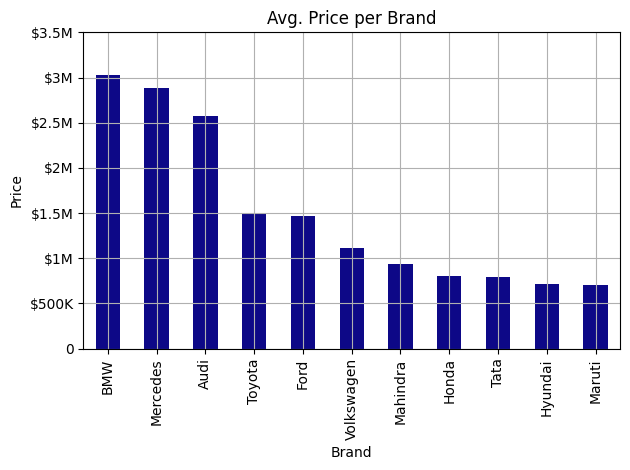

In [25]:
avg_prices = raw_data.groupby("Brand")["Price"].mean().sort_values(ascending=False)
avg_prices.plot(kind="bar", grid=True, colormap="plasma", title="Avg. Price per Brand")
plt.ylabel("Price")
plt.yticks(ticks=[0, .5e6, 1.0e6, 1.5e6, 2.0e6, 2.5e6, 3.0e6, 3.5e6], labels=["0", "$500K", "$1M", "$1.5M", "$2M", "$2.5M", "$3M", "$3.5M"])
plt.tight_layout()
plt.savefig("plots/Avg. Price per Brand.png", dpi=300)

# Data Preprocessing

In [6]:
df = raw_data.copy()

# Drop useless data
df.drop("Car_ID", axis=1, inplace=True)

# Enumerate object data
cols_to_enum = ["Brand", "Model", "Fuel_Type", "Transmission", "Owner_Type"]
for col_to_enum in cols_to_enum:
    enums = {value: i for i, value in enumerate(df[col_to_enum].unique())}
    df[col_to_enum] = df[col_to_enum].apply(lambda element: enums[element])

# Define X, y
X = df[["Brand", "Model", "Year", "Kilometers_Driven", "Fuel_Type", "Transmission", "Owner_Type", "Mileage", "Engine", "Power", "Seats", "Price"]].to_numpy()
y = df["Price"].to_numpy().reshape((len(df), 1))

# Input data normalization
X_scaler = MinMaxScaler()
X = X_scaler.fit_transform(X)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

# Convert to Tensor
X_train, X_test, y_train, y_test = torch.FloatTensor(X_train), torch.FloatTensor(X_test), torch.FloatTensor(y_train), torch.FloatTensor(y_test)
X_train.shape, y_train.shape

(torch.Size([80, 12]), torch.Size([80, 1]))

# Model Initialization

In [20]:
torch.manual_seed(42)
model = VehiclePriceIdentifier()
model, model.parameters_count

(VehiclePriceIdentifier(
   (fc1): Linear(in_features=12, out_features=16, bias=True)
   (fc2): Linear(in_features=16, out_features=8, bias=True)
   (fc3): Linear(in_features=8, out_features=1, bias=True)
 ),
 353)

# Model Training

Epoch: 2500 --> Loss: 461838811136.0
Epoch: 5000 --> Loss: 109877895168.0
Epoch: 7500 --> Loss: 57407963136.0
Epoch: 10000 --> Loss: 18644746240.0
Epoch: 12500 --> Loss: 903185088.0
Epoch: 15000 --> Loss: 547770.9375
Epoch: 17500 --> Loss: 0.04536132887005806
Epoch: 20000 --> Loss: 0.264892578125
Epoch: 22500 --> Loss: 0.03500976413488388
Epoch: 25000 --> Loss: 0.008056640625


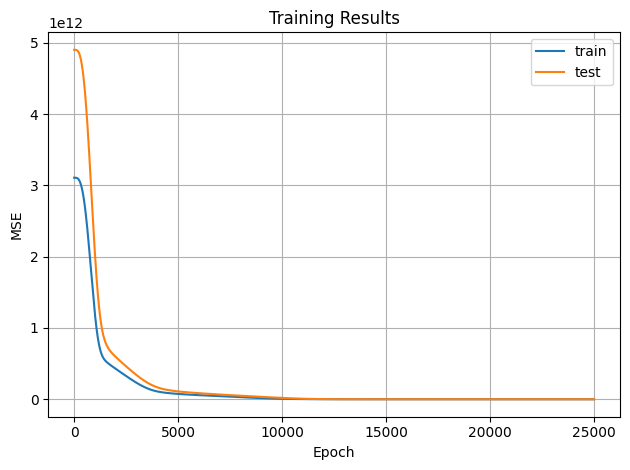

In [21]:
# Hyperparameters
learning_rate = .01
epochs = 25000

# Loss function
loss_function = nn.MSELoss()

# Optimization algorithm
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define tracking variable
train_losses = list()
test_losses = list()

# Set model state to 'train'
model.train()

# Process training
for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    
    out = model(X_train)
    loss = loss_function(out, y_train)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    with torch.no_grad():
        test_out = model(X_test)
        loss = loss_function(test_out, y_test)
        test_losses.append(loss.item())

    if epoch % 2500 == 0:
        print(f"Epoch: {epoch} --> Loss: {loss.item()}")

# Plot training results
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training Results")
plt.legend()
plt.tight_layout()
plt.savefig("plots/Training Results.png", dpi=300)


# Result

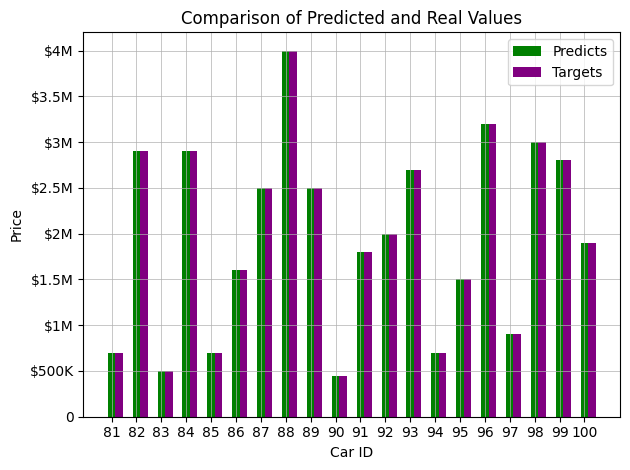

In [23]:
# Model`s Success
model.eval()
with torch.no_grad():
    out = model(X_test)
plt.bar(range(len(out)), out.flatten(), width=.3, color='green', label="Predicts")
plt.bar([e + .3 for e in range(len(out))], y_test.flatten(), width=.3, color='purple', label="Targets")
plt.grid(linewidth=.5)
plt.legend()
plt.title("Comparison of Predicted and Real Values")
plt.xlabel("Car ID")
plt.xticks(ticks=range(len(out)), labels=raw_data.Car_ID[-20:])
plt.ylabel("Price")
plt.yticks(ticks=[0, .5e6, 1.0e6, 1.5e6, 2.0e6, 2.5e6, 3.0e6, 3.5e6, 4.0e6], labels=["0", "$500K", "$1M", "$1.5M", "$2M", "$2.5M", "$3M", "$3.5M", "$4M"])
plt.tight_layout()
plt.savefig("plots/Comparison of Predicted and Real Values.png", dpi=300)


In [24]:
# MAE Score
mae_error = (sum(abs(out.flatten() - y_test.flatten())) / len(out)).item()
print(f"Model`s Absolute Error is {round(mae_error, 2)}$")

Model`s Absolute Error is 0.04$


# Model Saving

In [13]:
filename = f"models/vehicle_price_identifier-{model.parameters_count:,}.model"
torch.save(model, filename)
print(f"The model saved as {filename}")

The model saved as models/vehicle_price_identifier-353.model
